# Segmentation

This notebooks is adapted from [this page](https://vocalpy.readthedocs.io/en/latest/user/howto/segmentation-ir-metrics.html) of the VocalPy docs. It replicates part of the analysis from [Ghaffari Devos 2023](https://dael.euracoustics.org/confs/fa2023/data/articles/000897.pdf), adapting code from https://github.com/houtan-ghaffari/bird_syllable_segmentation.

In [1]:
import vocalpy as voc

/Users/tessa/opt/anaconda3/envs/acabb-env/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


We load an example as before.

In [2]:
example = voc.example('samba.wav')
sound = voc.Sound.read(example)

## the `vocalpy.Segments` data type

We're going to segment that sound with one of the methods built into the `vocalpy.segment` module.

In [5]:
segments = voc.segment.meansquared(sound)

This gives us back a `vocalpy.Segments` instance, with the starting index and length of a set of line segments.

In [6]:
segments

Segments(start_inds=array([  762,...36423, 47977]), lengths=array([ 2775,...10086, 15848]), labels=['', '', '', '', '', '', ...], sound=vocalpy.Sound(data=array([[0.003... 0.        ]]), samplerate=44100, path=/Users/tessa/opt/anaconda3/envs/acabb-env/lib/python3.11/site-packages/vocalpy/examples/samba.wav))

How many segments are there?The "raw data" of segments is given in term of sample indices, because on a computer we are always dealing with digital samples anyways.

But as humans it's easier for us to think

In [7]:
len(segments)

7

Because on a computer we are always dealing with digital samples, the "raw data" of segments is given in term of samples and indices: the index of the `start_sample` and the `length` of the segment in samples.

In [8]:
segments.start_inds

array([  762,  4096, 15570, 20724, 33547, 36423, 47977])

In [9]:
segments.lengths

array([ 2775, 10026,  4462, 10669,  2254, 10086, 15848])

But as humans it's often easier for us to think of segments in terms of seconds. The `Segments` class will convert to seconds for us.

In [10]:
segments.start_times

array([0.01727891, 0.09287982, 0.35306122, 0.46993197, 0.76070295,
       0.82591837, 1.08791383])

In [11]:
segments.durations

array([0.06292517, 0.22734694, 0.10117914, 0.24192744, 0.05111111,
       0.22870748, 0.35936508])

## the `vocalpy.Segmenter` class

Like when we made spectrograms, we can use a `Segmenter` class to capture the function and parameters we use, and to trivially parallelize processing a bunch of files.

For this notebook, We will use a subset of data from the [Bengalese Finch Song Repository](https://nickledave.github.io/bfsongrepo/).

Note this data is also built into VocalPy as an example, but that it gets downloaded when you call `vocalpy.example('bfsongrepo')` -- so we downloaded it ahead of time, to avoid having a room full of people downloaded MBs of data all at once.

In [12]:
bfsongrepo_dir = './data/Nicholson-Queen-Sober-2017-bfsongrepo-subset/'
wav_paths = voc.paths.from_dir(bfsongrepo_dir, 'wav')
csv_paths = voc.paths.from_dir(bfsongrepo_dir, 'csv')

In [13]:
sounds = [
    voc.Sound.read(wav_path)
    for wav_path in wav_paths
]

We will use the `voc.segment.meansquared` function, and to be extra explicit we use a data class, `voc.segment.MeanSquaredParams`, to represent the parameters we use.

In [14]:
callback = voc.segment.meansquared
params = voc.segment.MeanSquaredParams(threshold=1500, min_dur=0.01, min_silent_dur=0.006)
segmenter = voc.Segmenter(callback, params)
segments_list = segmenter.segment(sounds)

[########################################] | 100% Completed | 975.50 ms


In [15]:
segments_list[0]

Segments(start_inds=array([ 12057...3093, 225644]), lengths=array([2268, ..., 2138, 2747]), labels=['', '', '', '', '', '', ...], sound=vocalpy.Sound(data=array([[-0.00...-0.00753784]]), samplerate=32000, path=data/Nicholson-Queen-Sober-2017-bfsongrepo-subset/gy6or6_baseline_220312_0836.3.wav))

## Segmentation metrics

The goal of our evaluation is to get a measure of how close the segments from an algorithm are to a segmentation created by a human annotator. We will call the annotation created by the human annotator the *ground truth* or *reference* segmentation, and we will call the output of an algorithm the *hypothesis*. 

The algorithm in question is `vocalpy.segment.meansquared`. This algorithm is used by a Matlab GUI `evsonganaly` originally developed by Evren Tumer in the Brainard Lab, as used in [^3]. The version of the algorithm built into VocalPy is adapted from the Python implementation in the [`evfuncs` package](https://github.com/NickleDave/evfuncs).

What we want to understand is the role that different parameters play in the algorithm. 
To understand the role of these parameters, we will evaluate the output of `vocalpy.segment.meansquared` with and without the clean-up parameters.

## Baseline algorithm for segmentation

We will also compare with another algorithm that simply sets the threshold to the average of the energy, and doesn't do any post-processing to clean up.

Adapted from https://github.com/houtan-ghaffari/bird_syllable_segmentation.  
See https://dael.euracoustics.org/confs/fa2023/data/articles/000897.pdf for more detail.

In [18]:
import numpy as np
import scipy.signal

import vocalpy as voc


def average_envelope_threshold(sound: voc.Sound, cutoff=500, order=40) -> voc.Segments:
    """Segment audio by threshold with the average of the envelope.

    This function (1) high-pass filters the audio to reduce noise,
    (2) extracts the Hilbert envelope, (3) smooths the envelope with a Hann window,
    and then (4) thresholds the smoothed envelope to segment, 
    setting the threshold to average of the envelope.
    
    Adapted from https://github.com/houtan-ghaffari/bird_syllable_segmentation
    See https://dael.euracoustics.org/confs/fa2023/data/articles/000897.pdf for more detail.
    """
    if sound.data.shape[0] > 1:
        raise ValueError(
            f"The ``sound`` has {sound.data.shape[0]} channels, but segmentation is not implemented "
            "for sounds with multiple channels. This is because there can be a different number of segments "
            "per channel, which cannot be represented as a rectangular array. To segment each channel, "
            "first split the channels into separate ``vocalpy.Sound`` instances, then pass each to this function."
            "For example,\n"
            ">>> sound_channels = [sound_ for sound_ in sound]  # split with a list comprehension\n"
            ">>> channel_segments = [vocalpy.segment.meansquared(sound_) for sound_ in sound_channels]\n"
        )

    x = sound.data.squeeze(axis=0)

    sos = scipy.signal.butter(
        order, cutoff, btype="highpass", analog=False, output="sos", fs=sound.samplerate
    )
    x = scipy.signal.sosfiltfilt(sos, x)
    x = np.abs(scipy.signal.hilbert(x))
    win = scipy.signal.windows.hann(512)
    x = scipy.signal.convolve(x, win, mode='same') / sum(win)
    threshold = np.mean(x)
    above_threshold = x > threshold

    # convolving with h causes:
    # +1 whenever above_th changes from 0 to 1
    # and -1 whenever above_th changes from 1 to 0
    h = np.array([1, -1])
    above_convolved = np.convolve(h, above_threshold)
    onsets_sample = np.where(above_convolved > 0)[0]
    offsets_sample = np.where(above_convolved < 0)[0]
    lengths = offsets_sample - onsets_sample

    return voc.Segments(        
        start_inds=onsets_sample,
        lengths=lengths,
        sound=sound
    )    

### Information retrieval metrics

The metrics we will use to evaluate segmentation are adapted from the field of [information retrieval](https://en.wikipedia.org/wiki/Information_retrieval). Broadly speaking, this field builds systems to retrieve information, e.g. a program that lets a user query a database of documents (think Google Search). Methods for evaluating these systems have been borrowed by related fields, and by machine learning more broadly. For example, one can also conceive of querying a dataset of audio, as is done in [music information retrieval](https://musicinformationretrieval.com/), and information retrieval metrics have been adapted to evaluate the segentation of audio. See for example the segmentation metrics in the [`mir_eval`](https://craffel.github.io/mir_eval/#module-mir_eval.segment) package.

### Segment audio

To set ourselves up to analyze the results below, we will make a Python dictionary that maps a string `'name'` (for the algorithm we are testing) to the `list` of `vocalpy.Segments` returned by the algorithm. Since we test the same algorithm twice with different parameters, we will think of this name as a "condition" (the three conditions we outlined above).

In [16]:
algo_segments_map = {}

To actually get the results, we will write a loop.
Inside the loop, we will use the `vocalpy.Segmenter` class.  
This class takes has two parameters: a `callback` function, and the `params` (parameters) we will pass to that function.
Each time through the loop, we will make an instance of the `Segmenter` class by passing in a specific `callback` and set of `params` as the two arguments. Then when we call the `segment` method on that instance, the class will call the `callback` function.
So, at the top of the loop, we define a tuple of 3-element tuples that we iterate through. Each 3-element tuple has the condition `name`, the `callback` and the `params` we will use with it.

In [19]:
for name, callback, params in (
    ('meansquared', voc.segment.meansquared, voc.segment.MeanSquaredParams(threshold=1500, min_dur=0.01, min_silent_dur=0.006)),
    # here we set the parameters for minimum durations to zero, meaning "don't filter"
    ('meansquared-no-cleanup', voc.segment.meansquared, voc.segment.MeanSquaredParams(threshold=1500, min_dur=0., min_silent_dur=0.)),
    # our baseline. We set the params to None. We write it here so we have a value for "params" when we loop through these
    # even though the default is None
    ('average_envelope_threshold', average_envelope_threshold, None)
):
    print(f"Segmenting with algorithm/condition: '{name}'")
    segmenter = voc.Segmenter(callback, params)
    algo_segments_map[name] = segmenter.segment(sounds)

Segmenting with algorithm/condition: 'meansquared'
[########################################] | 100% Completed | 1.39 ss
Segmenting with algorithm/condition: 'meansquared-no-cleanup'
[########################################] | 100% Completed | 1.17 sms
Segmenting with algorithm/condition: 'average_envelope_threshold'
[########################################] | 100% Completed | 317.89 ms


### Get ground truth data

Now we need our reference segmentation to compare to.

We will need list of `vocalpy.Segments` for this too, but here we make them using `vocalpy.Annotation` that we load from the example datasets. These annotations contain the ground truth segmentation that we want to compare with the results from the algorithms.

In [20]:
annots = [
    voc.Annotation.read(csv_path, format='simple-seq')
    for csv_path in csv_paths
]

In [21]:
ref_segments_list = []
for annot, sound in zip(annots, sounds):
    start_inds = (annot.data.seq.onsets_s * sound.samplerate).astype(int)
    stop_inds = (annot.data.seq.offsets_s * sound.samplerate).astype(int)
    lengths = stop_inds - start_inds
    ref_segments_list.append(
        voc.Segments(
            start_inds,
            lengths,
            sound=sound,
        )
    )

### Compute metrics

Finally we use the functions in the {py:module}`vocalpy.metrics.segmentation.ir` module to compute metrics that we use to compare the segmentation algorithms.

The functions in this module expect two arguments: a `reference` segmentation, and a `hypothesis`. In other words, the ground truth and the output of some algorithm that we want to compare with that ground truth.

Notice that we use a `tolerance` of 10 milliseconds. This is a standard value used in previous work--you may find it instructive to vary this value and examine the results.

We will make a {py:class}`pandas.DataFrame` with the results, that we will then plot with {py:module}`seaborn`.

In [22]:
import pandas as pd

results_records = []  # will become a DataFrame


TOLERANCE = 0.01  # milliseconds


for name, hypothesis_segments_list in algo_segments_map.items():
    for reference, hypothesis in zip(ref_segments_list, hypothesis_segments_list):
        prec, _, _ = voc.metrics.segmentation.ir.precision(
            reference=reference.all_times,
            hypothesis=hypothesis.all_times,
            tolerance=0.01  # 10 milliseconds
        )
        rec, _, _ = voc.metrics.segmentation.ir.recall(
            reference=reference.all_times,
            hypothesis=hypothesis.all_times,
            tolerance=0.01  # 10 milliseconds
        )
        fscore, _, _ = voc.metrics.segmentation.ir.fscore(
            reference=reference.all_times,
            hypothesis=hypothesis.all_times,
            tolerance=TOLERANCE
        )
        for metric_name, metric_val in zip(
            ('precision', 'recall', 'fscore'),
            (prec, rec, fscore)
        ):
            results_records.append(
                {
                    'condition': name,
                    'metric': metric_name,
                    'value': metric_val,
                }
            )

results_df = pd.DataFrame.from_records(results_records)

We inspect the dataframe to check that it looks like what we expect.

In [23]:
results_df.head()

,condition,metric,value
0,meansquared,precision,0.954545
1,meansquared,recall,0.972222
2,meansquared,fscore,0.963303
3,meansquared,precision,0.868056
4,meansquared,recall,0.961538


Note this is in "long" form where we have a "variable" column -- in this case, the different metrics -- and the value that each "variable" takes on.

We could alternatively have the `DataFrame` in wide form, with columns for `'precision'`, `'recall'`, and `'fscore`, but as we'll see, the long form makes it easier to plot below.

### Visualize results

Now let's do some final clean-up of the dataframe, for plotting.

In [24]:
results_df['value'] = results_df['value'] * 100.

results_df['metric'] = results_df['metric'].map(
    {
        'fscore': '$F$-score (%)',
        'precision': 'Precision (%)',
        'recall': 'Recall (%)',
    },
    
)

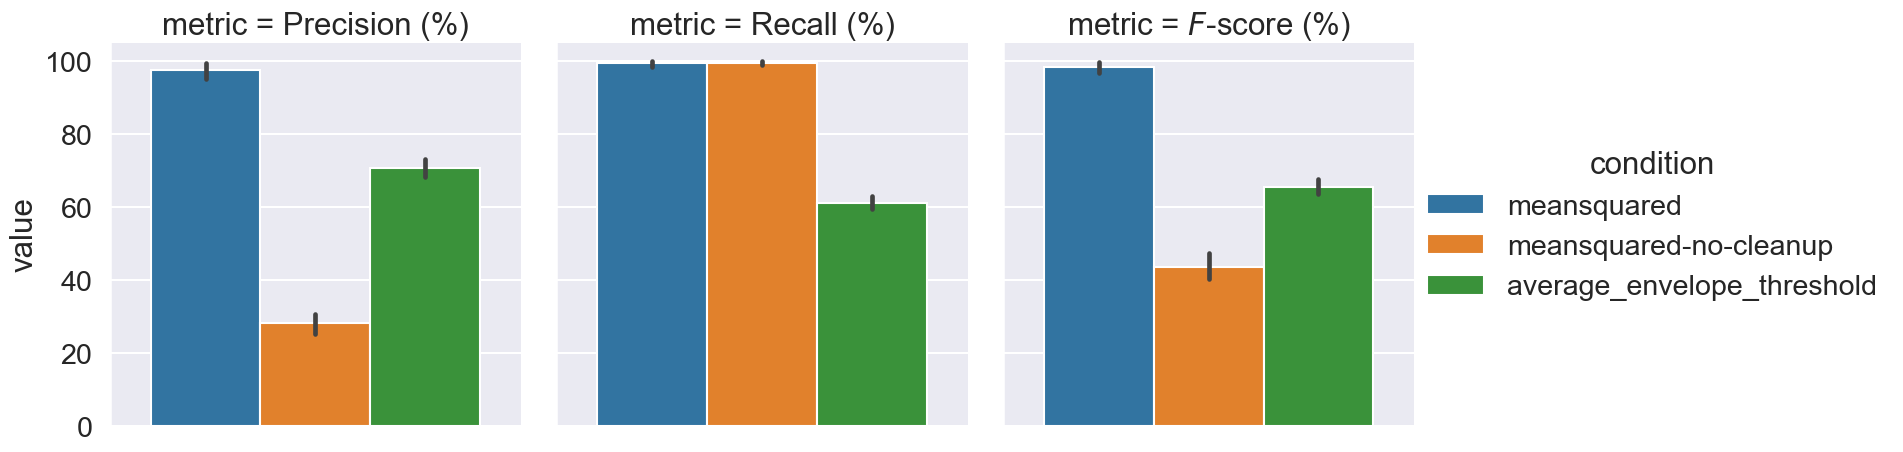

In [25]:
import seaborn as sns

sns.set_context('talk', font_scale=1.25)
sns.set_style('darkgrid')


g = sns.catplot(
    results_df,
    y='value',
    hue='condition',
    col='metric',
    kind='bar',
)

We can see that the `'meansquared'` algorithm *with* the clean-up steps has the highest precision and recall. Perhaps surprisingly, the `'meansquared'` algorithm *without* clean-up has a *lower* precision than the `average_envelope_threshold`, and even more surprisingly, it has the highest recall of all. We can understand this as follows: the `'meansquared'` algorithm finds "more" segments than the `'average_envelope_threshold'` algorithm--giving it a higher recall--but that also means it returns more false positives. More generally, a result like this would suggest that the clean-up steps have a bigger impact on performance than the methods used to compute the energy and the exact threshold used. Keep in mind that we've shown here is just a demo. To really draw this conclusion we'd need to do an extensive analysis across datasets, and be very clear about our intended use cases for the algorithm.